In [1]:
!rm -rf SaRaH/
!git clone https://github.com/alessandrocuda/SaRaH

Cloning into 'SaRaH'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 327 (delta 52), reused 80 (delta 17), pack-reused 212
Receiving objects: 100% (327/327), 103.90 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [17]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import sys
root_project = "/content/SaRaH/"
#root_project = "/Users/Alessandro/Dev/repos/SaRaH/"
#root_project = "/home/jupyter/SaRaH/"
sys.path.append(root_project)
from src.data.utils import load_data, set_unkmark
from src.features.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(tf.__version__)

2.4.1


# DATA

In [7]:
dataset_dev_path   = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
w2v_path       = root_project + "results/model/word2vec/word2vec.wordvectors"
w2v = KeyedVectors.load(w2v_path)

#load dev
df_dev = pd.read_csv(dataset_dev_path, sep=',')
dataset_dev_dict = load_data(df_dev, True)
set_unkmark(dataset_dev_dict["tokens"], w2v)
#index_to_key, key_to_index = get_index_key_association(w2v)
#dataset["int_tokens"] = get_int_seq(dataset["tokens"], index_to_key)  # for embedding layer
X_dev = get_data_to_emb(dataset_dev_dict["tokens"], w2v, 40, True)
X_dev_extra = np.array(dataset_dev_dict["extra_features"])
y_dev = np.array(dataset_dev_dict["target"])

#test tweet
df_test_tweet = pd.read_csv(dataset_test_tweets_path, sep=',')
dataset_test_tweet_dict = load_data(df_test_tweet, True)
set_unkmark(dataset_test_tweet_dict["tokens"], w2v)
X_test = get_data_to_emb(dataset_test_tweet_dict["tokens"], w2v, 40, True)
X_test_extra = np.array(dataset_test_tweet_dict["extra_features"])
y_test = np.array(dataset_test_tweet_dict["target"])

In [6]:
print(dataset_dev_dict["tokens"][0])
print(X_dev[0].shape)

['terrorismo', 'mettere', 'stato', 'soggezione', 'persone', 'renderle', 'innocue', 'mentre', 'qualcuno']
(40, 128)


## word len distribution

In [6]:
max_sequence_length = 0
for doc in dataset["tokens"]:
    if len(doc)>max_sequence_length:
        max_sequence_length = len(doc)
print("max sequence length %s" % max_sequence_length)

x = [len(doc) for doc in dataset["tokens"]]

tot_sentece_with = 0
more_then = 30
for len_sentece in x:
    if len_sentece >= more_then:
        tot_sentece_with += 1
print("total sentence with length more then {}: {}".format(more_then,tot_sentece_with))

max sequence length 74
total sentence with length more then 30: 328


(array([1.290e+02, 1.204e+03, 1.581e+03, 1.472e+03, 7.620e+02, 4.830e+02,
        6.050e+02, 3.230e+02, 1.130e+02, 9.200e+01, 3.400e+01, 1.200e+01,
        1.200e+01, 8.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 1.  ,  4.65,  8.3 , 11.95, 15.6 , 19.25, 22.9 , 26.55, 30.2 ,
        33.85, 37.5 , 41.15, 44.8 , 48.45, 52.1 , 55.75, 59.4 , 63.05,
        66.7 , 70.35, 74.  ]),
 <a list of 20 Patch objects>)

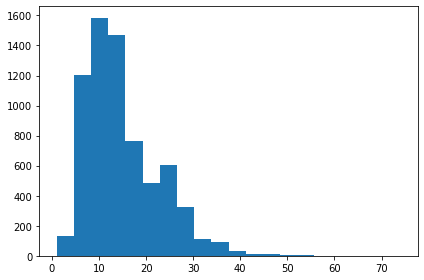

In [7]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(x, bins=20)

In [294]:
MAX_TEXT_LEN = 40
dataset["int_tokens"] = pad_sequences(dataset["int_tokens"], maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
print(dataset["tokens"][0])
print(dataset["int_tokens"][0])

['terrorismo', 'mettere', 'stato', 'soggezione', 'persone', 'renderle', 'innocue', 'mentre', 'qualcuno']
[15439  9152 14862 14314 10863 12287  7594  9074 11911     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


# build embedding_matrix 

In [269]:
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, key_to_index)

Vocab_size is 16848
Embedding_matrix loaded
Shape (16849, 128)


In [270]:
WORD_EMB_SIZE = 128

In [271]:
# test embedding
print(key_to_index[0])
print(key_to_index[100])
print(index_to_key[key_to_index[0]])
print(index_to_key[key_to_index[100]])
emb1 = w2v[key_to_index[100]]

inp = Input((2,))
out = Embedding(vocab_size, 128, input_length=2, weights=[embedding_matrix], trainable=False)(inp)
model = Model(inp, out)
emb2 = model.predict(np.array([0,100]).reshape((1, 2)))
np.array_equal(emb1,emb2[0][1])

<UNK>
abusivamente
0
100


True

# split

In [25]:
X_train, X_val, X_train_extra, X_val_extra, y_train, y_val = train_test_split(X_dev, X_dev_extra , y_dev, test_size=0.15, random_state=42)

# callback

In [64]:
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, f1_score

class ROCCallback(tf.keras.callbacks.Callback):
  
    def __init__(self, validation = (), verbose = 0):
        self.validation = validation
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.f1 = []
        self.val_f1 = []
    def on_epoch_end(self, epoch, logs=None):
        y_t =  self.validation[1]
        y_p =  np.where(self.model.predict(self.validation[0]) > 0.5, 1, 0)
        logs['val_f1'] =  f1_score (y_t, y_p, average='macro')
        if self.verbose >0:
          print("— val_f1: {}".format(logs['val_f1']))

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

input_val   = {"text": X_val, "extra": X_val2}
f1_callback = ROCCallback(validation = (input_val, y_val), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_f1",
                                        min_delta=0,
                                        patience=200,
                                        verbose=1,
                                        mode="max",
                                        baseline=0.72,
                                        restore_best_weights=True)

# model 1

In [9]:
def build_model(print_model=False):
  """ HyperParameters """
  FILTERS = 256
  pooling_units = 10
  output_dims = 1
  hidden_dims= 1

  text_seq_input = Input(shape=(40,128,), name="text")
  #text_embedding = Embedding(vocab_size, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
  #                            weights=[embedding_matrix], trainable=False)(text_seq_input)
  extra_feature = Input(shape=(5,), name = "extra")

  #text_embedding = Embedding(vocab_size, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
  #                            weights=[embedding_matrix], trainable=False)(text_seq_input)
  #text_dropout = Dropout(0.25)(text_embedding)

  filter_sizes = [2,3,4]
  convs = []
  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size, activation='relu')(text_seq_input)
      POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
      l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =3, padding='valid')(l_conv)   #Dynamic pooling
      #l_conv = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(l_pool)
      #POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
      #l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =1, padding='valid')(l_conv)   #Dynamic pooling
      convs.append(l_pool)

  l_merge = Concatenate(axis=1)(convs)
  l_cov1= Conv1D(110, 5, activation='relu')(l_merge)
  # since the text is too long we are maxooling over 100
  # and not GlobalMaxPool1D
  l_pool1 = MaxPool1D(10)(l_cov1)
  l_flat = Flatten()(l_pool1)
  l_flat = Concatenate(axis=1)([l_flat, extra_feature])
  l_hidden = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.007))(l_flat)
  l_hidden = Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.007))(l_hidden)
  l_out = Dense(1, activation='sigmoid')(l_hidden)  #dims output
  model_cnn = Model(inputs=[text_seq_input, extra_feature], outputs=l_out)
  if print_model:
    model_cnn.summary()
    tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
  return model_cnn


# model 2

In [ ]:
""" HyperParameters """
FILTERS = 256
pooling_units = 10
output_dims = 1
hidden_dims= 1

text_seq_input = Input(shape=(40,128,), name="text")
extra_feature = Input(shape=(5,), name = "extra")

#text_embedding = Embedding(vocab_size, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
#                            weights=[embedding_matrix], trainable=False)(text_seq_input)
#text_dropout = Dropout(0.25)(text_embedding)

filter_sizes = [1,2,3]
convs = []
for filter_size in filter_sizes:
    l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size, activation='relu')(text_seq_input)
    POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
    l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =3, padding='valid')(l_conv)   #Dynamic pooling
    l_conv = Conv1D(filters=64, kernel_size=filter_size, activation='relu')(l_pool)
    POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
    l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =1, padding='valid')(l_conv)   #Dynamic pooling
    convs.append(l_pool)

l_merge = Concatenate(axis=1)(convs)
l_global_pool = GlobalMaxPool1D()(l_merge)
l_cov1= Conv1D(32, 10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_merge)
# since the text is too long we are maxooling over 100
# and not GlobalMaxPool1D
l_pool1 = MaxPool1D(3)(l_cov1)
l_flat = Flatten()(l_pool1)
l_flat = Concatenate(axis=1)([l_flat,l_global_pool, extra_feature])
l_hidden = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_flat)
l_hidden = Dense(256, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_hidden)
l_hidden = Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.015))(l_hidden)
l_out = Dense(1, activation='sigmoid')(l_hidden)  #dims output
model_cnn = Model(inputs=[text_seq_input, extra_feature], outputs=l_out)
model_cnn.summary()
tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)


# train

In [26]:
model_cnn = build_model(True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 40, 128)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 39, 256)      65792       text[0][0]                       
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 38, 256)      98560       text[0][0]                       
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 37, 256)      131328      text[0][0]                       
____________________________________________________________________________________________

In [18]:
def binary_macro_f1(y_true, y_pred):
    tp = K.sum(y_true * K.round(y_pred))
    tn = K.sum((K.round(y_pred) - 1) * (y_true - 1))
    fp = K.sum(y_true * (1. - K.round(y_pred)))
    fn = K.sum((1. - y_true) * K.round(y_pred))

    precision_1 = tp / (tp +fp + K.epsilon())
    recall_1 = tp / (tp +fn + K.epsilon())
    f1_val_1 = 2*(precision_1*recall_1)/(precision_1+recall_1+K.epsilon())
    
    precision_0 = tn / (tn +fn + K.epsilon())
    recall_0 = tn / (tn +fp + K.epsilon())
    f1_val_0 = 2*(precision_0*recall_0)/(precision_0+recall_0+K.epsilon())
    macro_f1 = (f1_val_0 + f1_val_1) / 2

    return macro_f1

def f1_sklean_mapping_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def f1_macro(y_true, y_pred):
    return tf.py_function(f1_sklean_mapping_macro, (y_true, K.round(y_pred)), tf.double)


In [27]:
model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.007, amsgrad=True),
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True),
    metrics=[f1_macro]
)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_f1_macro", min_delta=0, patience=200, verbose=1, mode="max", restore_best_weights=False)

input_train = {"text": X_train, "extra": X_train_extra}
input_val   = {"text": X_val, "extra": X_val_extra}
history = model_cnn.fit(input_train, y_train, batch_size=128, epochs=200, validation_data=(input_val, y_val), callbacks=[es, mc], verbose = 0)
model_cnn = load_model('best_model.h5', custom_objects={'f1_macro': f1_macro})


Epoch 00001: val_f1_macro improved from -inf to 0.34178, saving model to best_model.h5

Epoch 00002: val_f1_macro improved from 0.34178 to 0.47838, saving model to best_model.h5

Epoch 00003: val_f1_macro improved from 0.47838 to 0.49650, saving model to best_model.h5

Epoch 00004: val_f1_macro improved from 0.49650 to 0.49975, saving model to best_model.h5

Epoch 00005: val_f1_macro did not improve from 0.49975

Epoch 00006: val_f1_macro did not improve from 0.49975

Epoch 00007: val_f1_macro improved from 0.49975 to 0.50520, saving model to best_model.h5

Epoch 00008: val_f1_macro did not improve from 0.50520

Epoch 00009: val_f1_macro improved from 0.50520 to 0.52602, saving model to best_model.h5

Epoch 00010: val_f1_macro did not improve from 0.52602

Epoch 00011: val_f1_macro improved from 0.52602 to 0.61683, saving model to best_model.h5

Epoch 00012: val_f1_macro did not improve from 0.61683

Epoch 00013: val_f1_macro did not improve from 0.61683

Epoch 00014: val_f1_macro did

In [28]:
y_val_pred = np.where(model_cnn.predict(input_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.7059025866813429
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       559
           1       0.67      0.69      0.68       467

    accuracy                           0.71      1026
   macro avg       0.71      0.71      0.71      1026
weighted avg       0.71      0.71      0.71      1026



In [29]:
input_test   = {"text": X_test, "extra": X_test_extra}
y_test_pred = np.where(model_cnn.predict(input_test) > 0.5, 1, 0)
print(f1_score(y_test, y_test_pred,average="macro"))
print(classification_report(y_test, y_test_pred))

0.6902324844289265
              precision    recall  f1-score   support

           0       0.81      0.58      0.67       694
           1       0.62      0.83      0.71       569

    accuracy                           0.69      1263
   macro avg       0.71      0.70      0.69      1263
weighted avg       0.72      0.69      0.69      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'val_f1'])


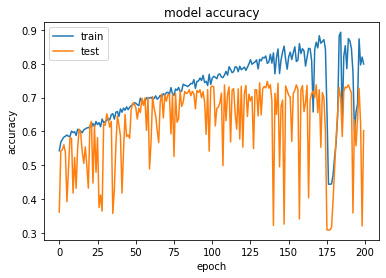

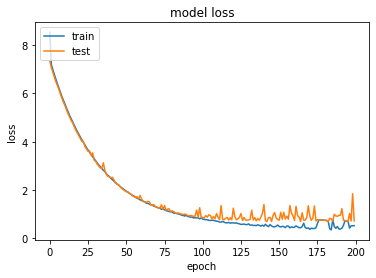

In [230]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_f1'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [278]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [322]:
cv_kfold = StratifiedKFold(n_splits=5, shuffle=True)

models = []
X = X_train
X_extra = X_train2
y = y_train
test   = {"text": X_val, "extra": X_val2}

y_test = y_val

for train_index, test_index in cv_kfold.split(X, y):
  model = build_model()
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      #optimizer=tf.keras.optimizers.Adam(learning_rate=0.007, amsgrad=True),
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.4, nesterov=True),
      metrics=["accuracy"]
  )
  input_train = {"text": X[train_index], "extra": X_extra[train_index]}
  input_val   = {"text": X[test_index], "extra": X_extra[test_index]}
  y_train = y[train_index]
  y_val = y[test_index]
  f1_callback1 = ROCCallback(validation = (input_val, y_val), verbose = 0)                                   
  best_callback1 = ReturnBestEarlyStopping(monitor="val_f1",
                                          min_delta=0,
                                          patience=200,
                                          verbose=0,
                                          mode="max",
                                          #baseline=0.72,
                                          restore_best_weights=True)
  model.fit(input_train, y_train, batch_size=128, epochs=200, validation_data=(input_val, y_val), callbacks=[f1_callback1, best_callback1], verbose=0)
  y_test_pred = np.where(model.predict(test) >0.5,1,0)
  print(f1_score(y_test,y_test_pred,average="macro"))
  models.append(model)


0.7020388105758069
0.7397104473272389
0.7321598940789346
0.7251979246114018
0.7258058638290028


In [396]:
def ensemble_predictions(members, testX):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(test) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

In [398]:
y_pred = ensemble_predictions(models, test)
print(classification_report(y_test,y_pred))


(5, 684)
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       370
           1       0.67      0.70      0.68       314

    accuracy                           0.70       684
   macro avg       0.70      0.70      0.70       684
weighted avg       0.70      0.70      0.70       684

